In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image 

import datetime as dt
import scipy as sp
import statsmodels.api as sm
import pandas as pd

import sklearn.cluster


In [2]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !git clone https://github.com/rkbono/GLY4451.git
    !pip install cartopy
    fpath = './GLY4451/'
else:
    print('Not running on CoLab')
    fpath = './'

Not running on CoLab


# Agenda
1. Intro to grids and np.meshgrid
1. Contour plots
1. Linear regresion (by hand)
1. Linear regression (with scipy)
1. Quick bootstrap
1. Quick monte carlo
1. Cluster analysis
1. Searching for global minimum

# Grids and np.meshgrid

Numpy meshgrid is a tool for numeric data manipulation in Python.

We use Numpy meshgrid to create a rectangular grid of x and y values.

More specifically, meshgrid creates coordinate values that enable us to construct a rectangular grid of values.

It does this in a somewhat roundabout way.

As inputs to the function, we provide 1-dimensional arrays with numeric values. These numeric values will be the coordinates of the new “meshgrid.”

The output of np.meshgrid is a set of Numpy arrays that contain the coordinates of this new grid space.

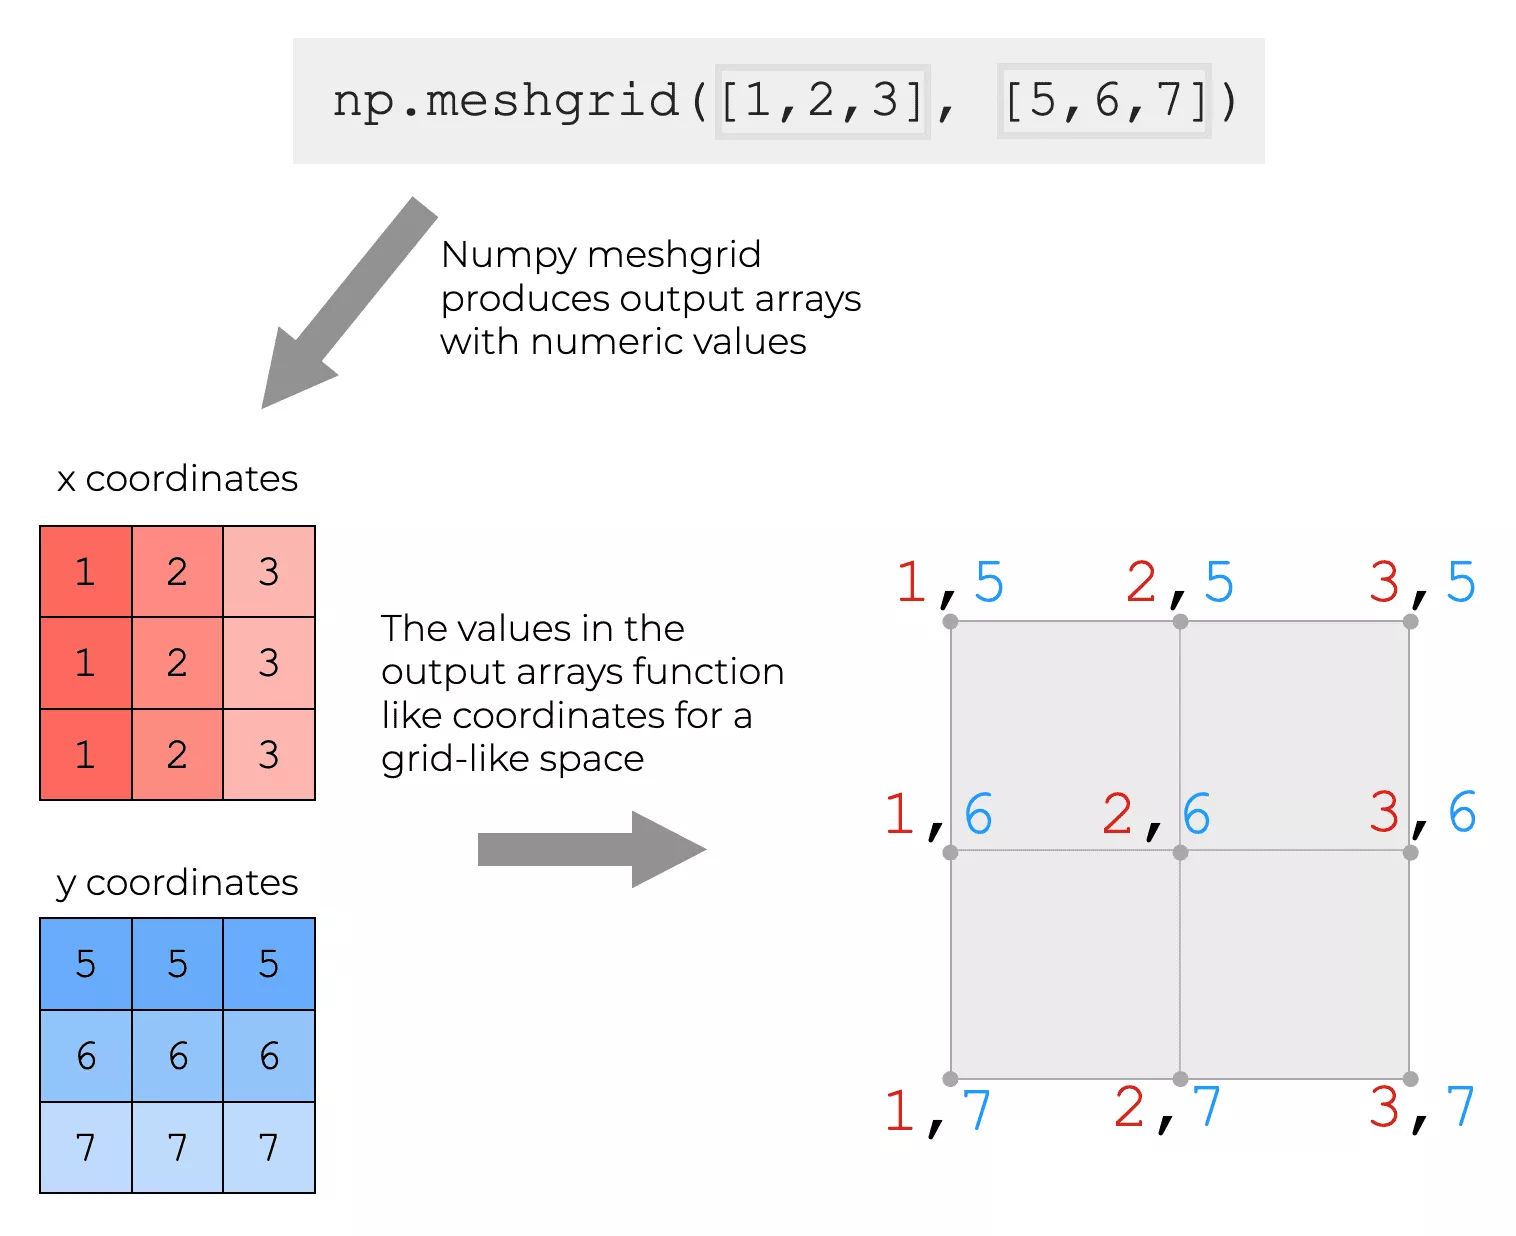

In [3]:
Image(fpath+'Figures/meshgrid2d.png')

# Contour plots


A contour line or isoline of a function of two variables is a curve along which the function has a constant value.

It is a cross-section of the three-dimensional graph of the function f(x, y) parallel to the x, y plane.

A contour plot is appropriate if you want to see how value Z changes as a function of two inputs X and Y, such that Z = f(X,Y). A contour line or isoline of a function of two variables is a curve along which the function has a constant value.

The independent variables x and y are usually restricted to a regular grid called meshgrid. The numpy.meshgrid creates a rectangular grid out of an array of x values and an array of y values.

Matplotlib API contains contour() and contourf() functions that draw contour lines and filled contours, respectively. Both functions need three parameters x,y and z.

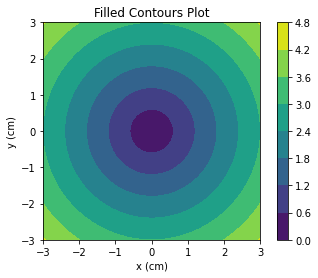

In [4]:
xlist = np.linspace(-3.0, 3.0, 100)
ylist = np.linspace(-3.0, 3.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = np.sqrt(X**2 + Y**2)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_aspect('equal')

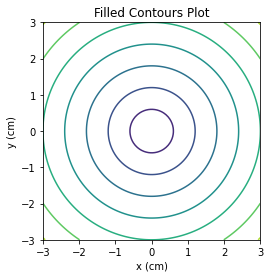

In [5]:
xlist = np.linspace(-3.0, 3.0, 100)
ylist = np.linspace(-3.0, 3.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = np.sqrt(X**2 + Y**2)
fig,ax=plt.subplots(1,1)
cp = ax.contour(X, Y, Z)
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_aspect('equal')

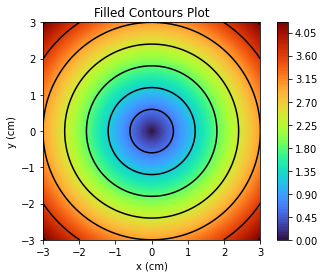

In [6]:
xlist = np.linspace(-3.0, 3.0, 100)
ylist = np.linspace(-3.0, 3.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = np.sqrt(X**2 + Y**2)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z,cmap=plt.cm.turbo,levels=100)
ax.contour(X,Y,Z,colors='k')
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_aspect('equal')

## Challenge:

Plot temperature with respect to age and depth for the crust near a spreading ridge

In [118]:
# Function to get temp given depth, age, initial temp and diffusitivity
def halfspace_temp(z,t,ta,ka):
    
    return ta*sp.special.erf(z/(2*np.sqrt(ka*t)))

# age from myr to seconds
fMyr = lambda t: dt.timedelta(weeks=52).total_seconds()*1e6*t

In [119]:
# constants
ka = 1e-6 # diffusivity
t0 = 1300 # initial temp

# initial vector of ages
tmyr = np.arange(0,100.1,1)

# initial vector of depths
dz = np.arange(0,150e3,1e3)

# colormap
cmap = plt.cm.magma

# levels for contours
lev = np.arange(0,1300+1e-5,100)

/var/folders/1s/wjx12t_j5h7gnb2g26c4dv8h0000gn/T/ipykernel_38322/3122820925.py:4: RuntimeWarning: divide by zero encountered in true_divide
  return ta*sp.special.erf(z/(2*np.sqrt(ka*t)))
/var/folders/1s/wjx12t_j5h7gnb2g26c4dv8h0000gn/T/ipykernel_38322/3122820925.py:4: RuntimeWarning: invalid value encountered in true_divide
  return ta*sp.special.erf(z/(2*np.sqrt(ka*t)))


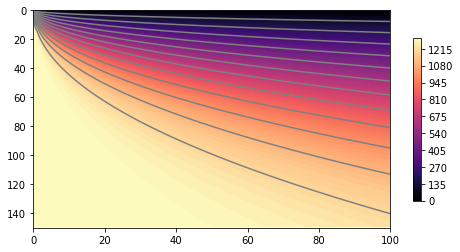

In [127]:
xm,ym = np.meshgrid(fMyr(tmyr),dz)

tzt = halfspace_temp(ym,xm,t0,ka)


fig = plt.figure(figsize=(8,4))
ax = fig.subplots(1,1)

ha = ax.contourf(xm/fMyr(1),ym/1e3,tzt,cmap='magma',levels=100)
ax.contour(xm/fMyr(1),ym/1e3,tzt,levels = np.arange(0,1300.01,100),colors='grey')
ax.set_ylim([150,0])

fig.colorbar(ha,ax=ax,shrink=0.75)

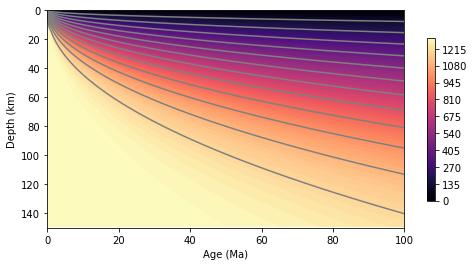

In [9]:
Image(fpath+'Figures/heat_contourf.png')

# Linear regression
## By "hand"

Let's put into practice what we talked about on Monday. Using numpy, let's implement our own version of a linear regression.

Recall:

$\beta = (X^{T}X)^{-1}X^{T}y$

So for a given set of observations **y** and independent regressor **x** we'd like to fit model parameters $\beta$. 

Let's work with just a simple curve (degree 2 polynomial) with the form:

$y = \beta_{0} + \beta_{1}x + \beta_{2}x^2$

This makes **X** our design matrix easy to setup. For each observation $y_i$, **X** will have a row containing [1, $x_i$] corresponding to the two model parameters in $\beta$. 

We can use **np.linalg** package to perform linear algebra operations as we solve for $\beta$

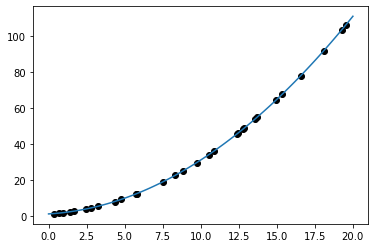

In [10]:
# Define some model parameters to find
beta_true = [1, 0.5,0.25]

# and a quick line function
fxy = lambda x: beta_true[0]+beta_true[1]*x+beta_true[2]*x**2
xv = np.linspace(0,20,100) # and simple line vector

# Let's generate some sample data with noise
xobs = np.random.uniform(0,20,size=30)
yobs = fxy(xobs)

# and take a look at the data
plt.plot(xobs,yobs,'ok',label='obs')
plt.plot(xv,fxy(xv),'-',label='true')

In [11]:
# Now lets set up our design matrix
X = np.vstack([np.ones_like(xobs),xobs,xobs**2]).T # added transpose

# and regress!
norm_matrix = np.linalg.inv(np.dot(X.T,X))
beta_guess = np.linalg.multi_dot([norm_matrix,X.T,yobs.T])
print(beta_guess)

beta_regress_np = np.linalg.lstsq(X,yobs,rcond=None)
print(beta_regress_np[0])

[1.   0.5  0.25]
[1.   0.5  0.25]


## Add some error

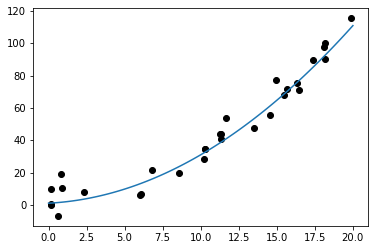

In [12]:
np.random.seed(1397)

# Let's generate some sample data with noise
xobs = np.random.uniform(0,20,size=30)
yobs = fxy(xobs)+np.random.normal(scale=5,size=xobs.shape) # random term adds Gaussian noise

# and take a look at the data
plt.plot(xobs,yobs,'ok',label='obs')
plt.plot(xv,fxy(xv),'-',label='true')

In [13]:
# Now lets set up our design matrix
X = np.vstack([np.ones_like(xobs),xobs,xobs**2]).T # added transpose

# and regress!
norm_matrix = np.linalg.inv(np.dot(X.T,X))
beta_guess = np.linalg.multi_dot([norm_matrix,X.T,yobs.T])
print(beta_guess)

beta_regress_np = np.linalg.lstsq(X,yobs,rcond=None)
print(beta_regress_np[0])

[ 4.8689977  -0.19232468  0.28668604]
[ 4.8689977  -0.19232468  0.28668604]


## Calculate $R^2$

In [14]:
ssr = np.sum([(yi-(beta_guess[0]+beta_guess[1]*xi+beta_guess[2]*xi**2))**2 for yi,xi in zip(yobs,xobs)])
print(ssr,beta_regress_np[1][0])

sst = np.sum((yobs-np.mean(yobs))**2)

r2 = 1-(ssr/sst)

print('R^2 = %.3f'%r2)

1167.247676993121 1167.2476769931216
R^2 = 0.967


## Plot fit

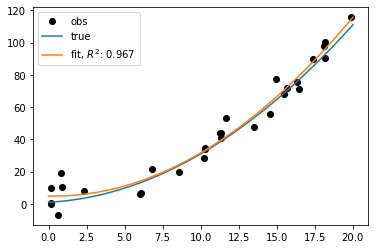

In [15]:
plt.plot(xobs,yobs,'ok',label='obs')
plt.plot(xv,fxy(xv),'-',label='true')
plt.plot(xv,[(beta_guess[0]+beta_guess[1]*xi+beta_guess[2]*xi**2) for xi in xv],'-',label='fit, $R^2$: '+'%.3f'%r2)
plt.legend()

# Challenge


# Bootstrapping!

In [16]:
# Now lets set up our design matrix
X = np.vstack([np.ones_like(xobs),xobs,xobs**2]).T # added transpose

# lets functionalize our regression
freg = lambda X,y: np.linalg.multi_dot([np.linalg.inv(np.dot(X.T,X)),X.T,y.T])

### Bootstrapping consists of the following steps:
1. Define a desired statistic(s) and a collector to hold the results
1. Set up a for loop to interate the desired number of realizations (ndraw >= 2500)
1. In each loop, draw with replacement from the observations to generate a synthetic dataset
1. With the synthetic dataset, perform statistics and collect result
1. After all fits are done, examine the resulting stats
1. ???
1. Profit!

In [17]:
ndraw = 10000

res = []

for ii in range(ndraw):
    ridx = np.random.randint(0,X.shape[0],size=X.shape[0])
    Xt = X[ridx,:]
    yt = yobs[ridx]
    res.append(freg(Xt,yt))
res = np.array(res)

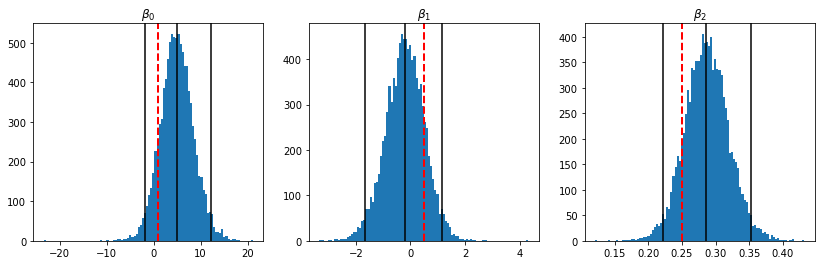

In [18]:
fig = plt.figure(figsize=(14,4))
ax = fig.subplots(1,3)

for ii in range(3):
    ax[ii].hist(res[:,ii],bins=100)
    ax[ii].axvline(beta_true[ii],color='red',linewidth=2,linestyle='--',label='True')
    [ax[ii].axvline(pp,color='k') for pp in np.percentile(res[:,ii],[2.5,50,97.5])]
    
    ax[ii].set_title(r'$\beta_{%d}$'%ii)

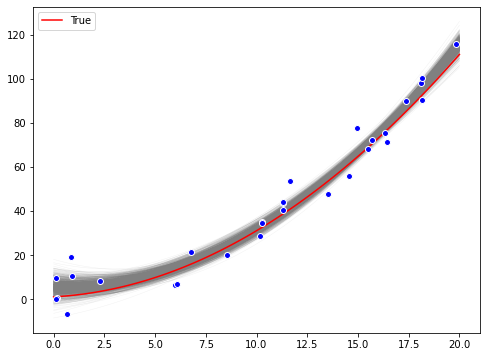

In [19]:
fig = plt.figure(figsize=(8,6))
ax = fig.subplots(1,1)

ax.plot(xobs,yobs,'ob',mec='w',zorder=100)
ax.plot(xv,fxy(xv),'-r',label='True',zorder=10)

for rr in res[::10]:
    ax.plot(xv,(rr[0]+rr[1]*xv+rr[2]*xv**2),'-',color='grey',linewidth=0.5,alpha=0.1,zorder=0)
    
ax.legend()

# Quick Monte Carlo

## Integration

In [20]:
# insert pi estimate

## Challenge - Monte Carlo Simulation

Goal: estimate the geotherm temperature at 20 km depth given surface heat flow and internal heat generation. But both observations are means w/ uncertainty based on several measurements that have been averaged together, so your temperature estimate should include that uncertainty. 

In [21]:
# function for getting temp from equilibrium geotherm and q0 at the surface
def geotherm_surf(z,q,a,k):
    """
    returns temp (degC) given depth z (m), surf heat flow q, internal heat a and conductivity k
    """
    return -(a/(2*k))*z**2 + q/k*z

# constants
k = 2.5 # conductivity
q0 = {'mean':0.058,'std':0.01}
A = {'mean':1.25e-6,'std':0.250e-6}

Text(0, 0.5, 'Depth (km)')

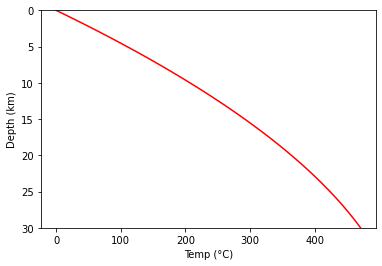

In [22]:
# look at geotherm assuming mean values
zz = np.linspace(0,30e3,100)

tz = geotherm_surf(zz,q0['mean'],A['mean'],k)

plt.plot(tz,zz/1e3,'-r')
plt.ylim([30,0])
plt.xlabel('Temp (°C)')
plt.ylabel('Depth (km)')

In [23]:
ndraw = 10000

# use numpy to generate numbers from a normal/gaussian distribution
qmc = np.random.normal(loc=q0['mean'],scale=q0['std'],size=ndraw)
amc = np.random.normal(loc=A['mean'],scale=A['std'],size=ndraw)

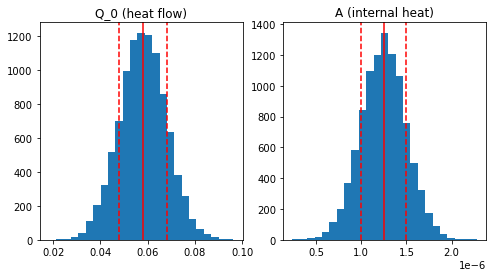

In [24]:
fig = plt.figure(figsize=(8,4))
ax = fig.subplots(1,2)

ax[0].hist(qmc,bins=25)
ax[0].axvline(q0['mean'],linestyle='-',color='r')
ax[0].axvline(q0['mean']+q0['std'],linestyle='--',color='r')
ax[0].axvline(q0['mean']-q0['std'],linestyle='--',color='r')
ax[0].set_title('Q_0 (heat flow)')

ax[1].hist(amc,bins=25)
ax[1].axvline(A['mean'],linestyle='-',color='r')
ax[1].axvline(A['mean']+A['std'],linestyle='--',color='r')
ax[1].axvline(A['mean']-A['std'],linestyle='--',color='r')
ax[1].set_title('A (internal heat)')

plt.savefig(fpath+'/Figures/q0_a_montecarlo.png')

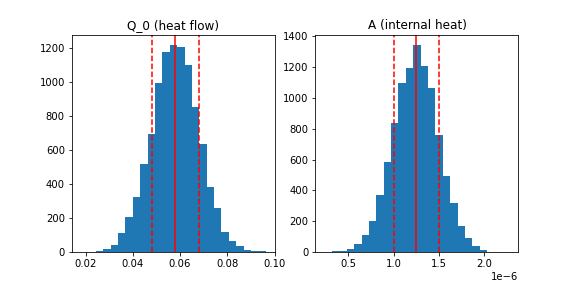

In [25]:
Image(fpath+'Figures/q0_a_montecarlo.png')

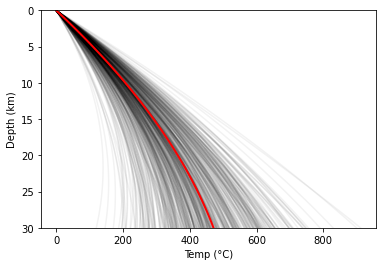

In [26]:
tzmc = [geotherm_surf(zz,q,a,k) for (q,a) in zip(qmc,amc)]

# look at range of geotherms
zz = np.linspace(0,30e3,100)

tz = geotherm_surf(zz,q0['mean'],A['mean'],k)

for tzz in tzmc[::20]:
    plt.plot(tzz,zz/1e3,'-k',alpha=0.05)

plt.plot(tz,zz/1e3,'-r',linewidth=2)
plt.ylim([30,0])
plt.xlabel('Temp (°C)')
plt.ylabel('Depth (km)');

plt.savefig(fpath+'/Figures/geotherm_mc.png')

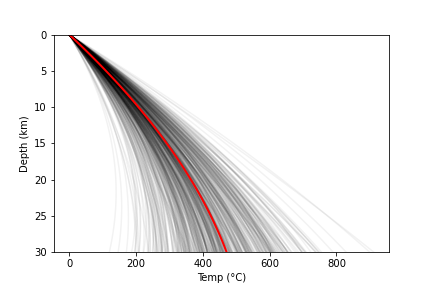

In [27]:
Image(fpath+'Figures/geotherm_mc.png')

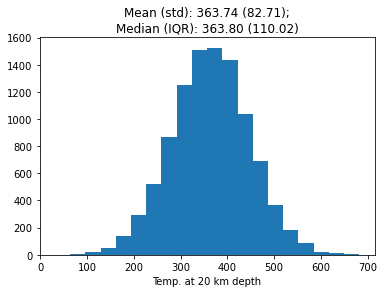

In [28]:
pred_temp = [geotherm_surf(20e3,q,a,k) for (q,a) in zip(qmc,amc)]
plt.hist(pred_temp,bins=20)
plt.xlabel('Temp. at 20 km depth');
plt.title('Mean (std): %.2f (%.2f);\nMedian (IQR): %.2f (%.2f)'%(
    np.mean(pred_temp),np.std(pred_temp),np.median(pred_temp),np.diff(np.percentile(pred_temp,[25,75])))
     );

plt.savefig(fpath+'/Figures/temp_at_20km.png')

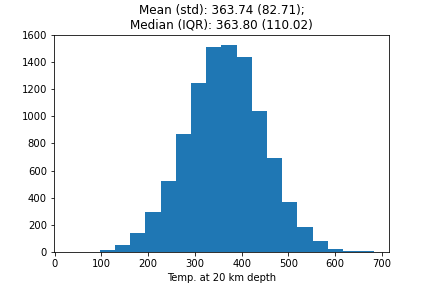

In [29]:
Image(fpath+'Figures/temp_at_20km.png')

# Clustering

We'll be reproducing an example of using k-means clustering to group a set of structural data on either side of a fold axis.

### The Orocopio Mountains Dataset
The dataset poles_data contains a dataset of poles to bedding planes from the Orocopio mountains. We learned about poles to planes in Lecture 22. If a rock is composed of sediments that are layed down flat on top of one another, then we would expect the pole to the plane to be vertical (because the plane itself is horizontal). If instead the plane is tilted, we might expect the pole to the plane to be in some other direction. Let's peek at a data set of poles from bedding planes measured in the  Orocopio Mountains.

In [30]:
poles_data=pd.read_csv(fpath+'Datasets/Orocopio_Poles_Data.csv')
poles_data.head()

,Lon,Lat,Pole_Az,Pole_Plunge
0,-115.684573,33.547327,340.0,13.0
1,-115.684341,33.547283,359.0,14.0
2,-115.684341,33.547283,347.0,11.0
3,-115.685112,33.547408,332.0,13.0
4,-115.685650,33.547545,12.0,32.0


We can use a modified equal area plot to plot the 'Pole_Az' and 'Pole Plunge' columns on an equal area projection to see what the bedding planes look like.

In [31]:
# Here's the equal angle function
EqualArea = lambda Pl: np.sqrt(2.)*90.*np.sin(np.radians(90.-Pl)/(2.))

def plot_equal_area(Azs,Pls,colors='black',cmap='RdBu',alpha=1):
    """
    Plots an Equal Angle plot for data d, colors are a string or list of colors
    to be passed to the points in data
    Note that this is different to the code in lecture 20 because it uses a
    scatter plot.
    
    Parameters:
    ____________
        Azs : np.array
            Azimuths of poles to planes
        Pls : np.array
            Plunges of poles to planes
            
    Returns:
    _________
        None
             
    """
    fig = plt.subplot(111, polar=True) 
    # set the coordinates (like for rose diagrams)
    fig.set_theta_direction(-1) # Reverse direction of degrees (CW)
    fig.set_theta_zero_location("N") # Specify 0-degrees as North
    # for this we want the full 90 degrees, so set the scale
    plt.polar([0],[90]) ## to scale grid
    # plot the first direction as a red dot
    fig.scatter(np.radians(Azs),(EqualArea(Pls)),c=colors,cmap=cmap,alpha=alpha)
    # plot the second direction as a blue square

    # make a list of contours to plot
    # notice use of list comprehension
    # label the azimuths at 20 degree intervals
    AzContours=range(0,360,20)
    AzLabels=[str(p) for p in AzContours]
    plt.thetagrids(AzContours,AzLabels)
    # and now the plunges
    PlContours=[EqualArea(a) for a in range(10,90,20)] ##don't include center or edge
    # make a list of labels
    PlLabels=[str(a) for a in range(10,90,20)]
    # draw on the plunge contours and label them
    plt.rgrids(PlContours,PlLabels)
    # label the plot
    plt.title('Equal Area Net');

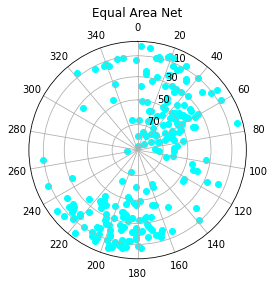

In [32]:
plot_equal_area(poles_data.Pole_Az,poles_data.Pole_Plunge,colors='cyan')

This is interesting! It seems that there are two 'clusters' with of bedding planes in different directions in this dataset, one to the north-east and one to the south-west. We want a way of separating these two clusters, but first let's think about what causes this. Is there some spatial relationship between where the different directions are found?

#### Quiver Plots and **plt.imshow( )**

To illustrate this we can use a type of plot known as a 'quiver plot'.  We will learn more about quiver plots in later lectures.  But for now, it draws an arrow with the direction of the plane on a plot. To do this, we need to convert the data from azimuth and plunge to x, y and z. We have the handy function **dir2cart( )** which we already know about.  

In [33]:
def dir2cart(Az,Pl):
    """
    converts polar directions to cartesian coordinates
    Inputs: 
        Dir[Azimuth,Plunge]:  directions in degreess
    Output:
        [X,Y,Z]: cartesian coordinates
    """
    Az=np.radians(Az)
    Pl=np.radians(Pl)
    return [np.cos(Az)*np.cos(Pl),np.sin(Az)*np.cos(Pl),np.sin(Pl)]

In [34]:
# get cartesian form of pole vectors
u,v,w=dir2cart(poles_data.Pole_Az.values,poles_data.Pole_Plunge.values)

In our coordinate system, $w$ is straight up, so planes with a steeper direction will have a smaller $u$ and $v$ components and a larger $w$ component, and so the arrows on the quiver plot will appear shorter in length.  

We will plot the quiver plot on top of a satellite image of the area, using the **plt.imread( )** and **plt.imshow( )** functions in **matplotlib**. These take an image and convert it into a coordinate system we can plot data onto.

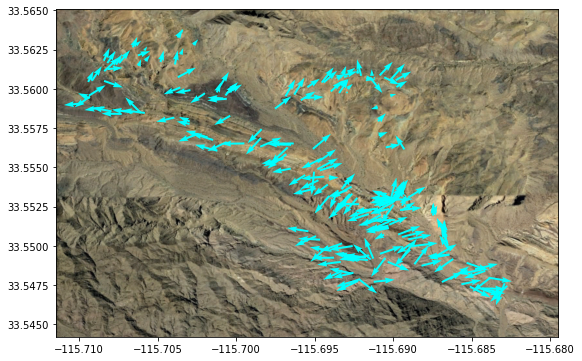

In [35]:
img = plt.imread(fpath+'Figures/GoogleEarthImage.png') #Reads in our image as a numpy array
extent = [-115.7115, -115.6795, 33.5442, 33.5651] #Sets the corners of the image in lat/lon for plotting
plt.figure(figsize=(9,13)) #Creates a new figure object to put the image on
plt.imshow(img, origin='upper', extent=extent) #Plots the satellite image.;

#Now let's plot the quivers onto the image 
#plt.quiver takes 4 arguments, x and y (locations of arrows), 
# and u and v (lengths of arrows in u and v directions).  
# We can also set the color so we can see the vectors better

plt.quiver(poles_data.Lon,poles_data.Lat,u,v,color='cyan');

This plot tells us an interesting story. Along the center of the satellite image runs a linear feature. To the north of this feature, we see that the arrows are pointing to the north-east. To the south-west of this image, the arrows are pointing south-west. What could be the cause of this pattern?

One probable cause would be a fold or anticline. For an illustration, see the image below. In an anticline, the horizontal layers are tilted away from the axis of the fold, so that the poles to the plane (arrows) are pointing away from the fold axis (dotted line). 

In [36]:
# Image('Figures/Fold_Diagram.png',width=300)

#### Clustering our data
Instead of "eyeballing" as we did at first, what if we wanted to automatically sort the two different directions into two different groups? How would we most easily do that? We don't really want to have to _train_ this dataset as we don't really care which group is which in this case, we just want some way of splitting the data into sensible groups. As such we might want to use some kind of _unsupervised_ machine learning process.

The **scikit-learn** package has a module called **sklearn.cluster** that allows us to solve this problem. There are many algorithms for different 'shapes' of clusters. Let's try converting our data into a format **scikit-learn** understands, then use the **Kmeans** clustering algorithm on them.

Remember from Lecture 16, that **scikit-learn** requires our data to be in a format in which  each datapoint has a set of _features_ which are a bit like coordinates.

In [37]:
input_data=np.array([poles_data.Pole_Az,poles_data.Pole_Plunge]).T
print(input_data[0:5])

[[340.  13.]
 [359.  14.]
 [347.  11.]
 [332.  13.]
 [ 12.  32.]]


Now let's do the clustering:

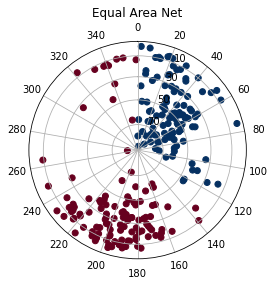

In [38]:
kmeans = sklearn.cluster.KMeans(n_clusters=2) #This tells us that we are using a clustering algorithm with 2 clusters

fit=kmeans.fit(input_data) #Fits the kmeans algorithm to our input data
clusternumbers=kmeans.predict(input_data) #Gives the cluster numbers for each of our clusters
#Plots the equal area with colors for clusters
plot_equal_area(poles_data.Pole_Az,poles_data.Pole_Plunge,colors=clusternumbers)

Hmm, it seems like this didn't work exactly as expected. Notice how there seems to be a change in cluster across the 0 degree Azimuth line? Let's plot Azimuth against plunge on an x,y plot to see why this didn't seem to work very well. 

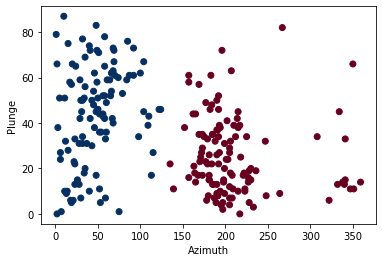

In [39]:
plt.scatter(poles_data.Pole_Az,poles_data.Pole_Plunge,c=clusternumbers,cmap='RdBu');
plt.xlabel('Azimuth')
plt.ylabel('Plunge');

The **Kmeans** algorithm treats data as if they were cartesian. But in geology, we often use directions that go from 0 to 360 which doesn't behave the same way as other cartesian data sets.  For example,an azimuth of 340 is closer to 200 than to 0 under this scheme. A simple solution to this would be to convert our azimuths and plunges to cartesian coordinates (as we did for the quiver plot) before clustering. Let's try again:

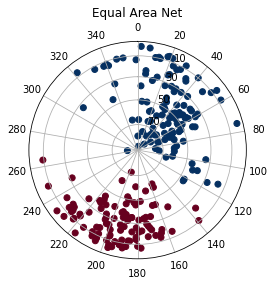

In [40]:
kmeans = sklearn.cluster.KMeans(n_clusters=2) #This tells us that we are using a clustering algorithm 
# with 2 clusters
input_data=np.array([u,v,w]).transpose() # make and array with u,v,w as the first, second and third rows
fit=kmeans.fit(input_data) #Fits the kmeans algorithm to our input data
clusternumbers=kmeans.predict(input_data) #Gives the cluster numbers for each of our clusters
#Plots the equal area with colors for clusters
plot_equal_area(poles_data.Pole_Az,poles_data.Pole_Plunge,colors=clusternumbers)

Much better! Let's see how it looks on the satellite image!

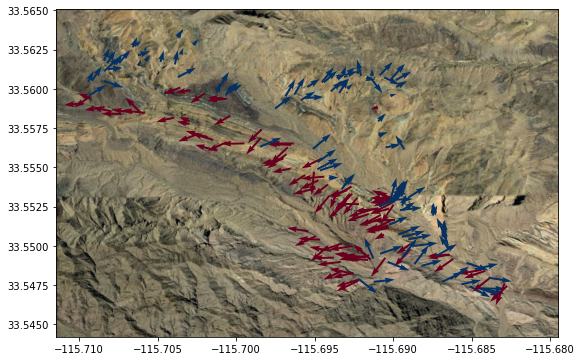

In [41]:
extent = [-115.7115, -115.6795, 33.5442, 33.5651]
img = plt.imread(fpath+'Figures/GoogleEarthImage.png')
plt.figure(figsize=(9,13))
plt.imshow(img, origin='upper', extent=extent)
plt.quiver(poles_data.Lon,poles_data.Lat,u,v,clusternumbers,cmap='RdBu'); #5th argument controls arrow color

Really cool.  It seems that there's something a bit more complicated going on here than just a single fold axis going down the middle, but we can see the broad trend and could probably even draw the axis in a lot of places now.
One final thing to note with **Kmeans**; you are not required  to choose the number of clusters.  However letting it work on its own generally doesn't work too well as it will try to find clusters with very similar sizes. If we try it with this example, we get a lot of clusters which don't really tell us much.

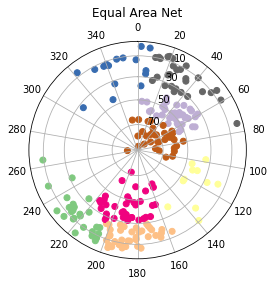

In [42]:
kmeans = sklearn.cluster.KMeans() #unspecified number of clusters
input_data=np.array([u,v,w]).transpose()
fit=kmeans.fit(input_data) #Fits the kmeans algorithm to our input data
clusternumbers=kmeans.predict(input_data) #Gives the cluster numbers for each of our clusters
#Plots the equal area with colors for clusters
plot_equal_area(poles_data.Pole_Az,poles_data.Pole_Plunge,colors=clusternumbers,cmap='Accent')

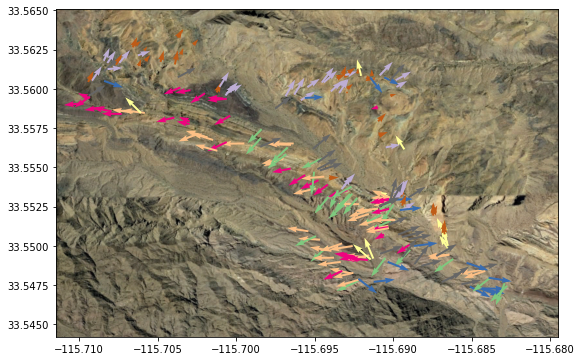

In [43]:
extent = [-115.7115, -115.6795, 33.5442, 33.5651]
img = plt.imread(fpath+'Figures/GoogleEarthImage.png')
plt.figure(figsize=(9,13))
plt.imshow(img, origin='upper', extent=extent)
plt.quiver(poles_data.Lon,poles_data.Lat,u,v,clusternumbers,cmap='Accent');

# Searching for the global minimum

Here we will try out some different approaches to find the global minimum for challenging equations

### Rosenbrock function

In [105]:
frb = lambda x: (x[0]-1)**2 + 100*(x[1]-x[0]**2)**2;

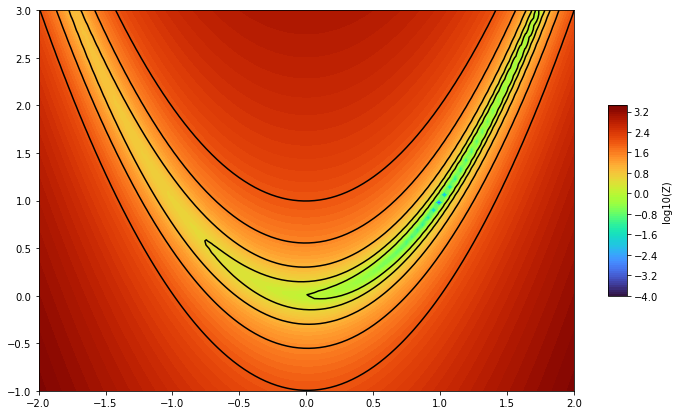

In [106]:
# Initialize figure 
fig = plt.figure(figsize=(12, 7))
ax = fig.subplots(1,1)

# Evaluate function
X = np.linspace(-2, 2, 100)
Y = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(X, Y)
Z = frb([X,Y])

# Plot the surface
surf = ax.contourf(X,Y,np.log10(Z),cmap=plt.cm.turbo,levels=100)
ax.contour(X,Y,np.log10(Z),colors='k',levels=np.arange(0,2+1e-5,0.5))
# ax.set_zlim(0, 200)
fig.colorbar(surf, shrink=0.5, aspect=10,label='log10(Z)')

In [107]:
frb([1,1])

0

In [108]:
# simple minimization
res = sp.optimize.minimize(frb,[0,0])
res

      fun: 2.844030241790906e-11
 hess_inv: array([[0.49482454, 0.98957635],
       [0.98957635, 1.98394216]])
      jac: array([ 3.98673382e-06, -2.84416264e-06])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 19
     njev: 24
   status: 0
  success: True
        x: array([0.99999467, 0.99998932])

In [109]:
res = sp.optimize.dual_annealing(frb,bounds=[[-5,5],[-5,5]])
res

     fun: 8.677112067951814e-12
 message: ['Maximum number of iteration reached']
    nfev: 4070
    nhev: 0
     nit: 1000
    njev: 23
  status: 0
 success: True
       x: array([0.99999706, 0.9999941 ])

In [110]:
res = sp.optimize.shgo(frb,bounds=[[-5,5],[-5,5]])
res

     fun: 2.0322688831494002e-11
    funl: array([2.03226888e-11])
 message: 'Optimization terminated successfully.'
    nfev: 85
     nit: 2
   nlfev: 80
   nlhev: 0
   nljev: 24
 success: True
       x: array([0.99999549, 0.99999098])
      xl: array([[0.99999549, 0.99999098]])

### Ackley Function

In [111]:
fack = lambda x: -20*np.exp(-0.2*np.sqrt(0.5*(x[0]**2+x[1]**2)))-\
                np.exp(0.5*(np.cos(2*np.pi*x[0])+np.cos(2*np.pi*x[1])))+np.e+20

In [112]:
fack([0,0])

0.0

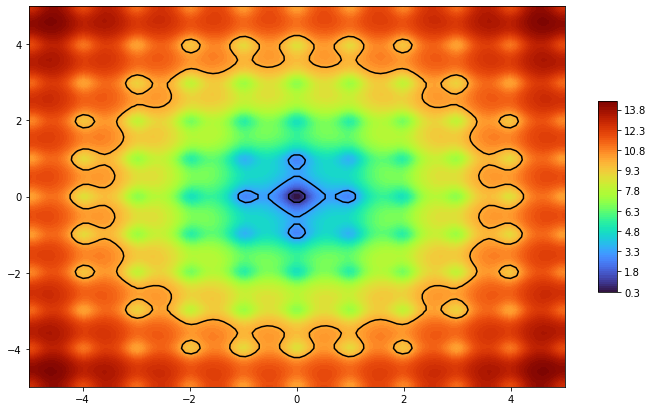

In [113]:
# Initialize figure 
fig = plt.figure(figsize=(12, 7))
ax = fig.subplots(1,1)

# Evaluate function
X = np.linspace(-5, 5, 100)
Y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(X, Y)
Z = fack([X,Y])

# Plot the surface
surf = ax.contourf(X,Y,Z,cmap=plt.cm.turbo,levels=100)
ax.contour(X,Y,np.log10(Z),colors='k',levels=np.arange(0,2+1e-5,0.5))
# ax.set_zlim(0, 200)
fig.colorbar(surf, shrink=0.5, aspect=10)

In [114]:
res = sp.optimize.minimize(fack,[3,3])
res

      fun: 9.001093478292008
 hess_inv: array([[ 0.50967948, -0.49032052],
       [-0.49032052,  0.50967948]])
      jac: array([3.57627869e-07, 3.57627869e-07])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 3
     njev: 6
   status: 0
  success: True
        x: array([2.97922395, 2.97922395])

In [115]:
res = sp.optimize.dual_annealing(fack,bounds=[[-5,5],[-5,5]])
res

     fun: 4.090750493901396e-08
 message: ['Maximum number of iteration reached']
    nfev: 4181
    nhev: 0
     nit: 1000
    njev: 60
  status: 0
 success: True
       x: array([-1.39763509e-08, -3.72015781e-09])

In [116]:
res = sp.optimize.shgo(fack,bounds=[[-5,5],[-5,5]])
res

     fun: 3.611617671595013e-10
    funl: array([3.61161767e-10])
 message: 'Optimization terminated successfully.'
    nfev: 48
     nit: 2
   nlfev: 43
   nlhev: 0
   nljev: 6
 success: True
       x: array([-9.02896020e-11, -9.02899355e-11])
      xl: array([[-9.02896020e-11, -9.02899355e-11]])